In [ ]:
#| default_exp learner
#| default_cls_lvl 3

In [ ]:
#| export
from seqdata.core import *
from seqdata.models.core import *
from fastai.basics import *
from fastai.callback.progress import *
from fastai.callback.tracker import *

Library "haste_pytorch" not found


/home/pheenix/Development/seqdata/seqdata/models/indrnn.py:109: UserWarning: Failed to import pynvrtc and cupy for indrnn model
  warnings.warn('Failed to import pynvrtc and cupy for indrnn model')


In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[-1,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=1000+1,stp_sz=1000,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
db = seq.dataloaders(get_hdf_files('test_data/battery/'))

In [ ]:
model = SimpleRNN(2,1)
lrn = Learner(db,model,loss_func=nn.MSELoss()).fit(1)

epoch,train_loss,valid_loss,time
0,12.533537,11.729511,00:03


## Callbacks

In [ ]:
#| export
class GradientClipping(Callback):
    "`Callback` cutts of the gradient of every minibtch at `clip_val`"
    def __init__(self, clip_val=10): self.clip_val = clip_val

    def after_backward(self):
        nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=GradientClipping(10)).fit(1)

epoch,train_loss,valid_loss,time
0,13.436076,12.546421,00:01


In [ ]:
#| export
class GradientNormPrint(Callback):
    "`Callback` prints the norm of the gradient of every minibtch"
    # def __init__(self, clip_val=10): self.clip_val = clip_val

    def before_step(self):
        grads = [
            param.grad.detach().flatten()
            for param in self.model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        print(f'Gradient norm: {norm:.2f}')

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=GradientNormPrint()).fit(1)

epoch,train_loss,valid_loss,time
0,13.069284,12.105098,00:00


Gradient norm: 10.43
Gradient norm: 10.41
Gradient norm: 10.27
Gradient norm: 10.23
Gradient norm: 9.98
Gradient norm: 10.18
Gradient norm: 10.37
Gradient norm: 10.51


In [ ]:
#| export
class GradientBatchFiltering(Callback):
    "`Callback` skips batches with a gradient norm larger than `filter_val`"
    def __init__(self, filter_val=10): self.filter_val = filter_val

    def before_step(self):
        grads = [
            param.grad.detach().flatten()
            for param in self.model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        if norm > self.filter_val:
            self.opt.zero_grad()
            print(f'Gradient norm: {norm:.2f} filtered')
            raise CancelBatchException()
        # print(f'Gradient norm: {norm:.2f}')

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),cbs=GradientBatchFiltering(11.0)).fit(1)

epoch,train_loss,valid_loss,time
0,11.460895,11.225883,00:01


Gradient norm: 11.22 filtered
Gradient norm: 11.14 filtered
Gradient norm: 11.96 filtered
Gradient norm: 11.55 filtered
Gradient norm: 12.51 filtered


In [ ]:
#| export
class WeightClipping(Callback):
    "`Callback` that clips the weights of a given module at `clip_limit` after every iteration"
    def __init__(self, module, clip_limit = 1):
        self.module = module
        self.clip_limit = clip_limit

    def after_batch(self):
#         import pdb; pdb.set_trace()
        for p in self.module.parameters():
            p.data.clamp_(-self.clip_limit,self.clip_limit)

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=WeightClipping(model,clip_limit=1)).fit(1)

epoch,train_loss,valid_loss,time
0,13.438492,12.496566,00:01


In [ ]:
#| export
class SkipFirstNCallback(Callback):
    "`Callback` skips first n samples from prediction and target, optionally `with_loss`"
    def __init__(self, n_skip = 0):
        self.n_skip = n_skip

    def after_pred(self):
        if self.training:
            with torch.no_grad():
                dl = self.learn.dls.train
                if (hasattr(dl,'rnn_reset') and dl.rnn_reset) or not hasattr(dl,'rnn_reset'): # if tbptt is used, only skip loss in the first minibatch
                    self.learn.pred = self.pred[:,self.n_skip:]
            #         import pdb; pdb.set_trace()
                    if isinstance(self.yb, tuple):
                        self.learn.yb = tuple([y[:,self.n_skip:] for y in self.yb])
                    else:
                        self.learn.yb = self.yb[:,self.n_skip:]

In [ ]:
#| export
class SkipNaNCallback(Callback):
    "`Callback` skips minibatches with a NaN loss"
    def after_loss(self): 
#         import pdb;pdb.set_trace()
        if torch.isnan(self.learn.loss):
            self.opt.zero_grad()
            raise CancelBatchException()

In [ ]:
#| export
class CancelNaNCallback(Callback):
    "`Callback` cancels trainig minibatches with a NaN loss"
    def after_loss(self): 
        if torch.isnan(self.learn.loss):
            raise CancelTrainException()

In [ ]:
#| export
class VarySeqLen(Callback):
    "`Callback` varies sequence length of every mini batch"
    def __init__(self, min_len = 50):
        self.min_len = min_len

    def before_batch(self):
        if self.training:
            with torch.no_grad():
        #         import pdb; pdb.set_trace()
                lx = self.xb[0].shape[1]
                ly = self.yb[0].shape[1]
                lim = random.randint(self.min_len,ly)
        #         import pdb; pdb.set_trace()
                if ly < lx:
                    self.learn.xb = tuple([x[:,:-(ly-lim)] for x in self.xb])
                else:
                    self.learn.xb = tuple([x[:,:lim] for x in self.xb])
                    
                self.learn.yb = tuple([y[:,:lim] for y in self.yb])

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=VarySeqLen(10)).fit(1)

epoch,train_loss,valid_loss,time
0,13.696853,12.885481,00:01


In [ ]:
#| export
from fastai.callback.all import *
class CB_TruncateSequence(Callback):
    "`Callback` varies sequence length of every mini batch"
    def __init__(self, truncate_length = 50,scheduler=sched_lin):
        self._truncate_length = truncate_length
        self._scheduler = scheduler

    def before_batch(self):
        if self.training:
            with torch.no_grad():
        #         import pdb; pdb.set_trace()
                lx = self.xb[0].shape[1]
                ly = self.yb[0].shape[1]
                lim = int(self._scheduler(ly-self._truncate_length,0,self.pct_train))
                if lim>0:
                    # print(lx,ly,lim)
            #         import pdb; pdb.set_trace()
                    self.learn.xb = tuple([x[:,:-lim] for x in self.xb])
                    self.learn.yb = tuple([y[:,:-lim] for y in self.yb])

In [ ]:
#| export
def sched_lin_p(start, end, pos, p=0.75): 
    return end if pos >= p else start + pos/p*(end-start)

In [ ]:
#| export
def sched_ramp(start, end, pos, p_left=0.1, p_right=0.5):
    if pos >= p_right: 
        return end
    elif pos <= p_left: 
        return start
    else: 
        return start + (end - start) * (pos - p_left) / (p_right - p_left)

[<matplotlib.lines.Line2D>]

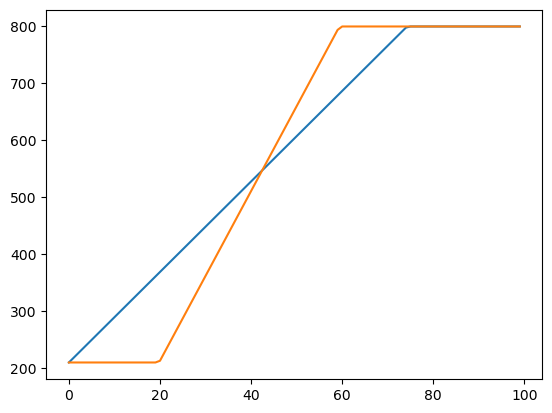

In [ ]:
init_sz = 200
pred_sz = 600
win_sz = init_sz+pred_sz
truncate_length = init_sz+10
plt.figure()
plt.plot([win_sz-sched_lin_p(win_sz-truncate_length,0,pct) for pct in np.linspace(0,1,100)])
plt.plot([win_sz-sched_ramp(win_sz-truncate_length,0,pct,0.2,0.6) for pct in np.linspace(0,1,100)])

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=CB_TruncateSequence(50,sched_lin_p)).fit(1)

epoch,train_loss,valid_loss,time
0,13.001372,12.055309,00:01


In [ ]:
#| export
class CB_AddLoss(Callback):
    '''Callback that adds the results of a given loss_function to the mini_batch after the original loss function has been applied'''
    def __init__(self,_loss_func,alpha=1.0):
        self._loss_func = _loss_func
        self.alpha = alpha
    
    def after_loss(self):
        if not self.training: return

        loss = self.alpha * self._loss_func(self.pred,self.y)
        self.learn.loss_grad = loss + self.learn.loss_grad
        self.learn.loss = loss + self.learn.loss

In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=CB_AddLoss(nn.MSELoss(),alpha=10)).fit(1)

epoch,train_loss,valid_loss,time
0,133.764038,11.119989,00:01


In [ ]:
# #| export
# class BatchLossFilter(Callback):
#     """ 
#     Callback that selects the hardest samples in every batch representing a percentage of the total loss.
#     """
#     def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
#         store_attr()  # Stores all passed arguments as class attributes

#     def before_batch(self):
#         """
#         Selects hardest samples before processing each batch.
#         """
#         if not self.training: return  # Skip if not in training mode
#         if self.schedule_func is None: loss_perc = self.loss_perc
#         else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
#         if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

#         with torch.no_grad():  # No gradients needed for the filtering operation
#             losses = self.filter_criterion(self.learn.model(self.x), self.y)  # Compute individual losses
#             if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
#             losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
#             idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
#             cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
#             idxs = idxs[:cut_idx]  # Select the hardest samples

#             self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)  # Filter the input batch
#             self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)  # Filter the output batch


In [ ]:
#| export
class BatchLossFilter(Callback):
    """ 
    Callback that selects the hardest samples in every batch representing a percentage of the total loss.
    """
    def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
        store_attr() 

    def after_pred(self):
        """
        Selects hardest samples after model prediction and before loss computation.
        """
        if not self.training: return  # Skip if not in training mode
        if self.schedule_func is None: loss_perc = self.loss_perc
        else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
        if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

        with torch.no_grad():  # No gradients needed for the filtering operation
            losses = self.filter_criterion(self.pred, self.y)  # Compute individual losses with model's predictions
            if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
            losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
            idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
            cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
            idxs = idxs[:cut_idx]  # Select the hardest samples

        self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)  # Filter the input batch
        self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)  # Filter the output batch
        self.learn.pred = self.pred[idxs]  # Update the predictions to match the filtered batch

In [ ]:
# #| export
# class BatchLossFilter(Callback):
#     """ 
#     Callback that selects the hardest samples in every batch representing a percentage of the total loss.
#     """
#     order = -9
#     def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
#         store_attr() 

#     def after_pred(self):
#         """
#         Calculate losses and select hardest samples after model prediction and before loss computation.
#         """
#         if not self.training: return  # Skip if not in training mode
#         if self.schedule_func is None: loss_perc = self.loss_perc
#         else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
#         if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

#         with torch.no_grad():  # No gradients needed for the filtering operation
#             losses = self.filter_criterion(self.pred, *self.learn.yb)  # Compute individual losses with model's predictions
#             if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
#             losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
#             idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
#             cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
#             self.idxs = idxs[:cut_idx]  # Store the indices of the hardest samples

#     def after_loss(self):
#         """
#         Recalculate the loss with the selected hardest samples.
#         """
#         if not self.training: return  # Skip if not in training mode
#         self.learn.loss_grad = self.loss_func(self.pred[self.idxs], *(yb[self.idxs] for yb in self.learn.yb))  # Compute the loss with hardest samples


In [ ]:
model = SimpleRNN(2,1)
Learner(db,model,loss_func=nn.MSELoss(),cbs=BatchLossFilter(loss_perc=0.8)).fit(10)

epoch,train_loss,valid_loss,time
0,14.888385,12.529611,00:01
1,13.323005,9.307961,00:01
2,10.347474,0.558078,00:01
3,7.393995,0.604716,00:01
4,5.599343,0.171353,00:01
5,4.334791,0.248623,00:01
6,3.455256,0.150388,00:01
7,2.791892,0.130818,00:01
8,2.287410,0.105615,00:01
9,1.890067,0.093564,00:01


In [ ]:
#| export
from fastai.callback.hook import *
@delegates()
class TimeSeriesRegularizer(HookCallback):
    "Callback that adds AR and TAR to the loss, calculated by output of provided layer"
    run_before=TrainEvalCallback
    def __init__(self,alpha=0.0, beta=0.0,dim = None,detach=False, **kwargs):
        if 'modules' not in kwargs: print('Warning: No module was provided to TimeSerieRegularizer')
        super().__init__(detach=detach,**kwargs)
        store_attr('alpha,beta,dim')
        
    def hook(self, m, i, o): 
#         import pdb; pdb.set_trace()
        if isinstance(o,torch.Tensor):
            self.out = o
        else:
            self.out = o[0]
        
        #find time axis if not already provided
        if self.dim is None:
            self.dim = np.argmax([0,self.out.shape[1],self.out.shape[2]])
    
    def after_loss(self):
        if not self.training: return
        
        h = self.out.float()
        
        if self.alpha != 0.:  
            l_a = float(self.alpha) * h.pow(2).mean()
            self.learn.loss_grad += l_a 
            
        if self.beta != 0. and h.shape[self.dim]>1:
            h_diff = (h[:,1:] - h[:,:-1]) if self.dim == 1 else (h[:,:,1:] - h[:,:,:-1])
            l_b = float(self.beta) * h_diff.pow(2).mean()
            self.learn.loss_grad += l_b

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),cbs=[TimeSeriesRegularizer(1.0,1.2)]).fit(1)

/opt/conda/envs/env_fastai/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,time
0,0.890481,2.966484,00:01


In [ ]:
#| export
class ARInitCB(Callback):
    '''Adds the target variable to the input tuple for autoregression'''
    def before_batch(self):
#         import pdb; pdb.set_trace()
        self.learn.xb = tuple([*self.xb,*self.yb])

In [ ]:
Learner(db,model,loss_func=nn.MSELoss()).fit(1)

epoch,train_loss,valid_loss,time
0,1.116969,0.098006,00:01


In [ ]:
#| export
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    *modified version of https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8*
    
    Call multiple time for transparent overlays, representing the mean gradients
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             pdb.set_trace()
            ave_grads.append(0 if p.grad is None else p.grad.abs().mean().cpu())
            max_grads.append(0 if p.grad is None else p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
#| export

class CB_PlotGradient(Callback):
    '''Plot the Gradient Distribution for every trainable parameter'''
    
    def __init__(self, n_draws=20): self.n_draws = n_draws
    
    def begin_fit(self):
        '''Create a new figure to plot in'''
        plt.figure()
        plt.tight_layout()
        
    def after_backward(self):
        '''plot the gradient for every layer of the current minibatch'''
        # plotting n_draws times at the whole training
        if self.iter % (max(self.n_epoch*self.n_iter//self.n_draws,1)) == 0:
#         if self.iter == self.n_iter-1:
            plot_grad_flow(self.learn.model.named_parameters())
#             print('done')

epoch,train_loss,valid_loss,time
0,0.080903,0.066813,00:01


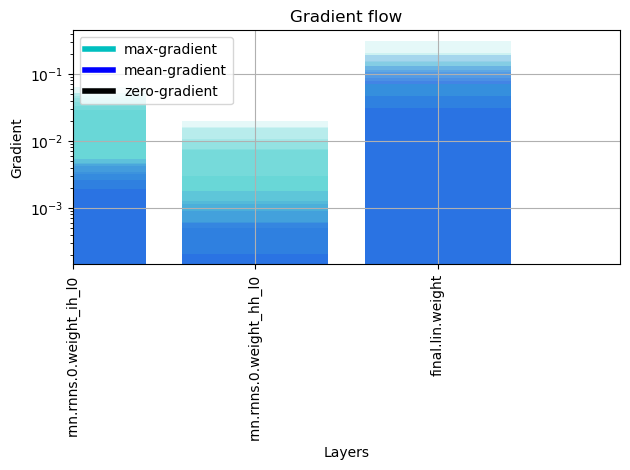

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),cbs=CB_PlotGradient()).fit(1)

## Loss Functions

In [ ]:
#| export
import functools

def ignore_nan(func):
    '''remove nan values from tensors before function execution, reduces tensor to a flat array, apply to functions such as mse'''
    @functools.wraps(func)
    def ignore_nan_decorator(*args, **kwargs):
#         mask = ~torch.isnan(args[-1]) #nan mask of target tensor
#         args = tuple([x[mask] for x in args]) #remove nan values
        mask = ~torch.isnan(args[-1][...,-1]) #nan mask of target tensor
        args = tuple([x[mask,:] for x in args]) #remove nan values
        return func(*args, **kwargs)
    return ignore_nan_decorator

In [ ]:
n = 1000
y_t = torch.ones(32,n,6)
y_t[:,20]=np.nan
y_p = torch.ones(32,n,6)*1.1

In [ ]:
(~torch.isnan(y_t)).shape

torch.Size([32, 1000, 6])

In [ ]:
y_t.shape

torch.Size([32, 1000, 6])

In [ ]:
assert torch.isnan(mse(y_p,y_t))

In [ ]:
#| export
mse_nan = ignore_nan(mse)

In [ ]:
test_close(mse_nan(y_p,y_t),0.01)

In [ ]:
#| export
import functools

def float64_func(func):
    '''calculate function internally with float64 and convert the result back'''
    @functools.wraps(func)
    def float64_func_decorator(*args, **kwargs):
        typ = args[0].dtype
        args = tuple([x.double() if issubclass(type(x),Tensor ) else x for x in args]) #remove nan values
        return func(*args, **kwargs).type(typ)
    return float64_func_decorator

In [ ]:
Learner(db,model,loss_func=float64_func(nn.MSELoss())).fit(1)

epoch,train_loss,valid_loss,time
0,0.060548,0.045865,00:00


In [ ]:
#| export
def SkipNLoss(fn,n_skip=0):
    '''Loss-Function modifier that skips the first n samples of sequential data'''
    @functools.wraps(fn)
    def _inner( input, target):
        return fn(input[:,n_skip:],target[:,n_skip:])
    
    return _inner

In [ ]:
Learner(db,model,loss_func=SkipNLoss(nn.MSELoss(),n_skip=30)).fit(1)

epoch,train_loss,valid_loss,time
0,0.021734,0.016329,00:01


In [ ]:
#| export
def CutLoss(fn,l_cut=0,r_cut=None):
    '''Loss-Function modifier that skips the first n samples of sequential data'''
    @functools.wraps(fn)
    def _inner( input, target):
        return fn(input[:,l_cut:r_cut],target[:,l_cut:r_cut])
    
    return _inner

In [ ]:
Learner(db,model,loss_func=CutLoss(nn.MSELoss(),l_cut=30)).fit(1)

epoch,train_loss,valid_loss,time
0,0.011926,0.009467,00:00


In [ ]:
#| export
def weighted_mae(input, target):
    max_weight = 1.0
    min_weight = 0.1
    seq_len = input.shape[1]
    weights = torch.logspace(start=torch.log10(torch.tensor(max_weight)),
                             end=torch.log10(torch.tensor(min_weight)),
                             steps=seq_len,device=input.device)
    weights = (weights / weights.sum())[None,:,None]

    return ((input-target).abs()*weights).sum(dim=1).mean()

In [ ]:
Learner(db,model,loss_func=SkipNLoss(weighted_mae,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,time
0,0.110726,0.041002,00:00


In [ ]:
#| export
def RandSeqLenLoss(fn,min_idx=1,max_idx=None,mid_idx=None):
    '''Loss-Function modifier that truncates the sequence length of every sequence in the minibatch inidiviually randomly.
    At the moment slow for very big batchsizes.'''
    @functools.wraps(fn)
    def _inner( input, target):
        bs,l,_ = input.shape
        if 'max_idx' not in locals():  max_idx = l
        if 'mid_idx' not in locals():  mid_idx = min_idx#+(max_idx-min_idx)//4
        # len_list = torch.randint(min_idx,max_idx,(bs,))
        len_list = np.random.triangular(min_idx,mid_idx,max_idx,(bs,)).astype(int)
        return torch.stack([fn(input[i,:len_list[i]],target[i,:len_list[i]]) for i in range(bs)]).mean()
    return _inner

In [ ]:
Learner(db,model,loss_func=RandSeqLenLoss(nn.MSELoss())).fit(1)

epoch,train_loss,valid_loss,time
0,0.358758,0.335703,00:00


In [ ]:
#| export
def fun_rmse(inp, targ): 
    '''rmse loss function defined as a function not as a AccumMetric'''
    return torch.sqrt(F.mse_loss(inp, targ))

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),metrics=SkipNLoss(fun_rmse,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.019399,0.018038,0.062226,00:00


In [ ]:
#| export
def cos_sim_loss(inp, targ): 
    '''rmse loss function defined as a function not as a AccumMetric'''
    return (1-F.cosine_similarity(inp,targ,dim=-1)).mean()

In [ ]:
Learner(db,model,loss_func=cos_sim_loss,metrics=SkipNLoss(fun_rmse,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.000389,0.000045,0.070419,00:00


In [ ]:
#| export
def cos_sim_loss_pow(inp, targ): 
    '''rmse loss function defined as a function not as a AccumMetric'''
    return (1-F.cosine_similarity(inp,targ,dim=-1)).pow(2).mean()

In [ ]:
Learner(db,model,loss_func=cos_sim_loss_pow,metrics=SkipNLoss(fun_rmse,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.000808,0.000053,0.070781,00:00


In [ ]:
#| export
def nrmse(inp, targ): 
    '''rmse loss function scaled by variance of each target variable'''
    mse = (inp-targ).pow(2).mean(dim=[0,1])
    var = targ.var(dim=[0,1])
    return (mse/var).sqrt().mean()

In [ ]:
db.one_batch()[0].shape

torch.Size([64, 1000, 2])

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),metrics=SkipNLoss(nrmse,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,nrmse,time
0,0.028354,0.026250,0.279318,00:00


In [ ]:
#| export
def nrmse_std(inp, targ): 
    '''rmse loss function scaled by standard deviation of each target variable'''
    mse = (inp-targ).pow(2).mean(dim=[0,1])
    var = targ.std(dim=[0,1])
    return (mse/var).sqrt().mean()

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),metrics=SkipNLoss(nrmse_std,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,nrmse_std,time
0,0.026429,0.023874,0.118766,00:01


In [ ]:
#| export
def mean_vaf(inp,targ):
    return (1-((targ-inp).var()/targ.var()))*100

In [ ]:
Learner(db,model,loss_func=nn.MSELoss(),metrics=SkipNLoss(mean_vaf,n_skip=30)).fit(1)

epoch,train_loss,valid_loss,mean_vaf,time
0,0.024885,0.023829,99.366516,00:00


# Create Learner Models
Create Learner with different kinds of models with fitting Parameters and regularizations.

In [ ]:
#| export
def get_inp_out_size(db):
    '''returns input and output size of a timeseries databunch'''
    tup = db.one_batch()
    inp = tup[0].shape[-1]
    out = tup[1].shape[-1]
    return inp,out

In [ ]:
test_eq(get_inp_out_size(db),(2,1)) 

## RNN Learner
The Learners include model specific optimizations. Removing the first n_skip samples of the loss function of transient time, greatly improves training stability. In

In [ ]:
#| export
@delegates(SimpleRNN, keep=True)
def RNNLearner(db,loss_func=nn.MSELoss(),metrics=[fun_rmse],n_skip=0,cbs=None,**kwargs):
    inp,out = get_inp_out_size(db)
    model = SimpleRNN(inp,out,**kwargs)
  
    skip = partial(SkipNLoss,n_skip=n_skip)
        
    metrics= [skip(f) for f in metrics]
    loss_func = skip(loss_func)
        
    lrn = Learner(db,model,loss_func=loss_func,opt_func=ranger,metrics=metrics,cbs=cbs)
    return lrn

In [ ]:
RNNLearner(db,rnn_type='gru').fit(1,1e-4)

epoch,train_loss,valid_loss,fun_rmse,time
0,13.630052,13.705876,3.691432,00:00


## TCN Learner
Performs better on multi input data. Higher beta values allow a way smoother prediction. Way faster then RNNs in prediction. 

In [ ]:
#| export
@delegates(TCN, keep=True)
def TCNLearner(db,hl_depth=3,loss_func=nn.MSELoss(),metrics=[fun_rmse],n_skip=0,cbs=None,**kwargs):
    inp,out = get_inp_out_size(db)
    n_skip = 2**hl_depth if n_skip is None else n_skip
    model = TCN(inp,out,hl_depth,**kwargs)
  
    skip = partial(SkipNLoss,n_skip=n_skip)
        
    metrics= [skip(f) for f in metrics]
    loss_func = skip(loss_func)
        
    lrn = Learner(db,model,loss_func=loss_func,opt_func=ranger,metrics=metrics,cbs=cbs)
    return lrn

In [ ]:
TCNLearner(db).fit(1)

epoch,train_loss,valid_loss,fun_rmse,time
0,10.064171,10.216249,3.183029,00:01


## CRNN Learner

In [ ]:
#| export
@delegates(CRNN, keep=True)
def CRNNLearner(db,loss_func=nn.MSELoss(),metrics=[fun_rmse],n_skip=0,cbs=None,**kwargs):
    inp,out = get_inp_out_size(db)
    model = CRNN(inp,out,**kwargs)
  
    skip = partial(SkipNLoss,n_skip=n_skip)
        
    metrics= [skip(f) for f in metrics]
    loss_func = skip(loss_func)
        
    lrn = Learner(db,model,loss_func=loss_func,opt_func=ranger,metrics=metrics,cbs=cbs)
    return lrn

In [ ]:
CRNNLearner(db,rnn_type='gru').fit(1,3e-2)

epoch,train_loss,valid_loss,fun_rmse,time
0,7.338480,5.862404,2.406979,00:01


## Autoregressive Learner

In [ ]:
#| export
@delegates(TCN, keep=True)
def AR_TCNLearner(db,hl_depth=3,alpha=1,beta=1,early_stop=0,metrics=None,n_skip=None,**kwargs):
    n_skip = 2**hl_depth if n_skip is None else n_skip
    skip = partial(SkipNLoss,n_skip=n_skip)
    
    inp,out = get_inp_out_size(db)
    model = AR_Model(TCN(inp+out,out,hl_depth,**kwargs),ar=False,rf=n_skip)
    model.init_normalize(db.one_batch())
    
    cbs=[ARInitCB(),TimeSeriesRegularizer(alpha=alpha,beta=beta,modules=[model.model.conv_layers[-1]]),SaveModelCallback()]
    if early_stop > 0:
        cbs += [EarlyStoppingCallback(patience=early_stop)]
        
    if metrics is None: metrics=SkipNLoss(fun_rmse,n_skip)
        
    lrn = Learner(db,model,loss_func=nn.MSELoss(),opt_func=ranger,metrics=metrics,cbs=cbs)
    return lrn

In [ ]:
#| export
@delegates(SimpleRNN, keep=True)
def AR_RNNLearner(db,alpha=0,beta=0,early_stop=0,metrics=None,n_skip=0,fname='model',**kwargs):
    skip = partial(SkipNLoss,n_skip=n_skip)
    
    inp,out = get_inp_out_size(db)
    model = AR_Model(SimpleRNN(inp+out,out,**kwargs),ar=False,hs=True)
    model.init_normalize(db.one_batch())
    
    cbs=[ARInitCB(),TimeSeriesRegularizer(alpha=alpha,beta=beta,modules=[model.model.rnn]),SaveModelCallback()]
    if early_stop > 0:
        cbs += [EarlyStoppingCallback(patience=early_stop)]
        
    if metrics is None: metrics=SkipNLoss(fun_rmse,n_skip)
        
    lrn = Learner(db,model,loss_func=nn.MSELoss(),opt_func=ranger,metrics=metrics,cbs=cbs)
    return lrn

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()